In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')


In [5]:
# Step 2: Load the Datasets

customers = pd.read_csv('Customers.csv')
print(f"Loaded Customers.csv with {customers.shape[0]} records and {customers.shape[1]} columns.")

products = pd.read_csv('Products.csv')
print(f"Loaded Products.csv with {products.shape[0]} records and {products.shape[1]} columns.")

transactions = pd.read_csv('Transactions.csv')
print(f"Loaded Transactions.csv with {transactions.shape[0]} records and {transactions.shape[1]} columns.")


Loaded Customers.csv with 200 records and 4 columns.
Loaded Products.csv with 100 records and 4 columns.
Loaded Transactions.csv with 1000 records and 7 columns.


In [6]:
#  Step 3: Data Cleaning

# Checking for missing values
print("Missing Values in Customers:\n", customers.isnull().sum())
print("\nMissing Values in Products:\n", products.isnull().sum())
print("\nMissing Values in Transactions:\n", transactions.isnull().sum())

# Drop rows with missing values if any
customers.dropna(inplace=True)
products.dropna(inplace=True)
transactions.dropna(inplace=True)

print("\nAfter dropping missing values:")
print(f"Customers: {customers.shape}")
print(f"Products: {products.shape}")
print(f"Transactions: {transactions.shape}")

Missing Values in Customers:
 CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Missing Values in Products:
 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Missing Values in Transactions:
 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

After dropping missing values:
Customers: (200, 4)
Products: (100, 4)
Transactions: (1000, 7)


In [7]:
# Step 4: Data Type Conversion

# Convert 'SignupDate' and 'TransactionDate' to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Ensure numerical columns have correct data types
transactions['Quantity'] = transactions['Quantity'].astype(int)
transactions['TotalValue'] = transactions['TotalValue'].astype(float)
products['Price'] = products['Price'].astype(float)



Converting date columns to datetime format and ensuring correct data types...
Data type conversion completed.


In [8]:


# Step 5: Feature Engineering

# Merge Transactions with Products to get product details like Category and Price
transactions_products = transactions.merge(products, on='ProductID', how='left')

# 1. Total Spend per Customer
customer_spend = transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spend.rename(columns={'TotalValue': 'TotalSpend'}, inplace=True)

# 2. Average Transaction Value per Customer
customer_avg_trans = transactions.groupby('CustomerID')['TotalValue'].mean().reset_index()
customer_avg_trans.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)

# 3. Number of Transactions per Customer
customer_num_trans = transactions.groupby('CustomerID')['TransactionID'].nunique().reset_index()
customer_num_trans.rename(columns={'TransactionID': 'NumTransactions'}, inplace=True)

# 4. Favorite Category per Customer
favorite_category = (
    transactions_products
    .groupby(['CustomerID', 'Category'])['Quantity']
    .sum()
    .reset_index()
    .sort_values(['CustomerID', 'Quantity'], ascending=[True, False])
    .drop_duplicates(subset=['CustomerID'], keep='first')
    .rename(columns={'Category': 'FavoriteCategory'})
)

# 5. Merge all Customer Features
customer_features = (
    customers
    .merge(customer_spend, on='CustomerID', how='left')
    .merge(customer_avg_trans, on='CustomerID', how='left')
    .merge(customer_num_trans, on='CustomerID', how='left')
    .merge(favorite_category, on='CustomerID', how='left')
)

# 6. Fill Missing Values from Merges
customer_features['TotalSpend'] = customer_features['TotalSpend'].fillna(0)
customer_features['AvgTransactionValue'] = customer_features['AvgTransactionValue'].fillna(0)
customer_features['NumTransactions'] = customer_features['NumTransactions'].fillna(0)
customer_features['FavoriteCategory'] = customer_features['FavoriteCategory'].fillna('Unknown')

# 7. Calculate Tenure in Days
latest_transaction_date = transactions['TransactionDate'].max()
customer_features['TenureDays'] = (latest_transaction_date - customer_features['SignupDate']).dt.days

# 8. Distinct Categories Purchased per Customer
distinct_categories = transactions_products.groupby('CustomerID')['Category'].nunique().reset_index()
distinct_categories.rename(columns={'Category': 'DistinctCategories'}, inplace=True)

# 9. Recency: Days Since Last Transaction
last_transaction = transactions.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction['Recency'] = (latest_transaction_date - last_transaction['TransactionDate']).dt.days

# 10. Merge DistinctCategories and Recency into Customer Features
customer_features = customer_features.merge(distinct_categories, on='CustomerID', how='left') \
                                     .merge(last_transaction[['CustomerID', 'Recency']], on='CustomerID', how='left')

# 11. Fill Missing Values for DistinctCategories and Recency
customer_features['DistinctCategories'] = customer_features['DistinctCategories'].fillna(0)
customer_features['Recency'] = customer_features['Recency'].fillna(customer_features['TenureDays'])

# 12. Drop Unnecessary Columns
customer_features.drop(['CustomerName', 'SignupDate'], axis=1, inplace=True)

print("\nFinal Customer Features:")
print(customer_features.head())


Performing feature engineering...
Feature engineering completed.

Final Customer Features:
  CustomerID         Region  TotalSpend  AvgTransactionValue  NumTransactions  \
0      C0001  South America     3354.52              670.904              5.0   
1      C0002           Asia     1862.74              465.685              4.0   
2      C0003  South America     2725.38              681.345              4.0   
3      C0004  South America     5354.88              669.360              8.0   
4      C0005           Asia     2034.24              678.080              3.0   

  FavoriteCategory  Quantity  TenureDays  DistinctCategories  Recency  
0      Electronics       7.0         902                 3.0     55.0  
1       Home Decor       6.0        1049                 2.0     25.0  
2       Home Decor       6.0         296                 3.0    125.0  
3       Home Decor       9.0         811                 3.0      4.0  
4      Electronics       4.0         866                 2.0 

In [9]:

# Step 6: Feature Scaling and Encoding
# Define numerical and categorical features
numerical_features = ['TotalSpend', 'AvgTransactionValue', 'NumTransactions',
                      'TenureDays', 'DistinctCategories', 'Recency']
categorical_features = ['Region', 'FavoriteCategory']

# Set up ColumnTransformer for scaling and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fitting and transforming the data
feature_matrix = preprocessor.fit_transform(customer_features)

# Convert to dense array if it's a sparse matrix
if hasattr(feature_matrix, "toarray"):
    feature_matrix = feature_matrix.toarray()
    print("Converted sparse matrix to dense array.")
else:
    print("Feature matrix is already a dense NumPy array.")

print(f"Feature matrix shape: {feature_matrix.shape}")



Scaling numerical features and encoding categorical features...
Feature matrix is already a dense NumPy array.
Feature matrix shape: (200, 15)



Determining the optimal number of clusters using Davies-Bouldin Index and Silhouette Score...
Clusters: 2, DB Index: 1.7511, Silhouette Score: 0.1937
Clusters: 3, DB Index: 1.6595, Silhouette Score: 0.1815
Clusters: 4, DB Index: 1.7509, Silhouette Score: 0.1593
Clusters: 5, DB Index: 1.6362, Silhouette Score: 0.1579
Clusters: 6, DB Index: 1.7207, Silhouette Score: 0.1427
Clusters: 7, DB Index: 1.7911, Silhouette Score: 0.1194
Clusters: 8, DB Index: 1.8019, Silhouette Score: 0.1251
Clusters: 9, DB Index: 1.8324, Silhouette Score: 0.1200
Clusters: 10, DB Index: 1.9105, Silhouette Score: 0.1111


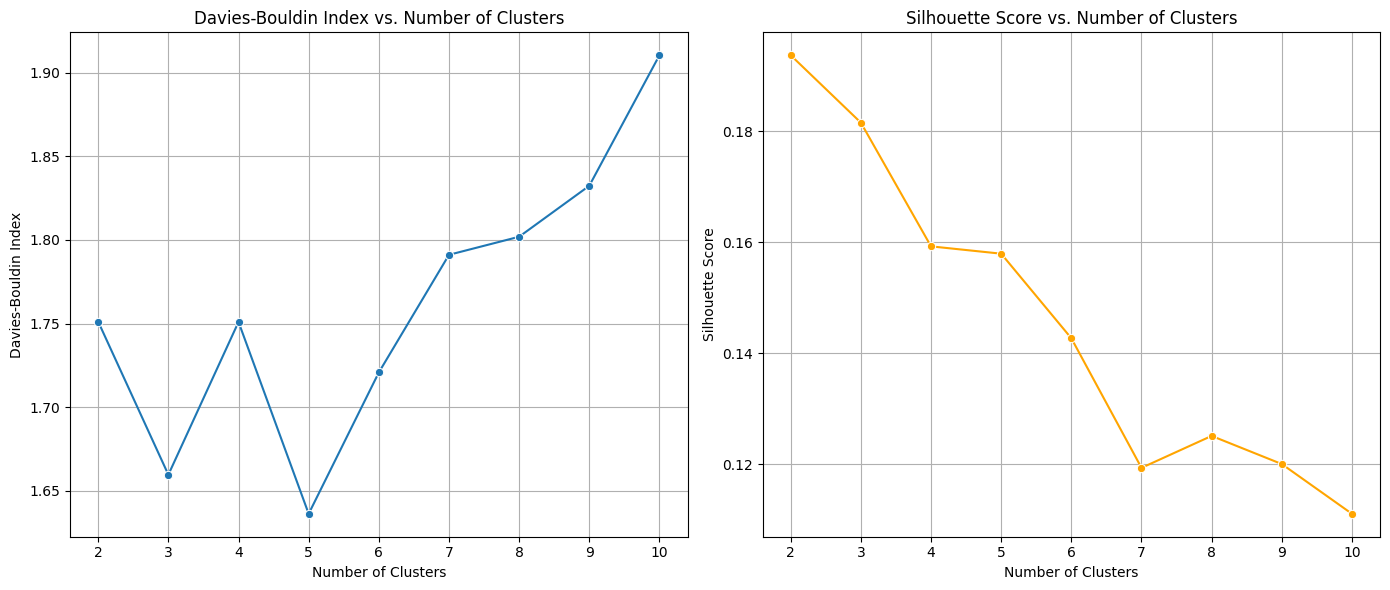

In [10]:

# Step 7: Determining the Optimal Number of Clusters

# Define the range for number of clusters
range_n_clusters = range(2, 11)

# Lists to store evaluation metrics
db_scores = []
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(feature_matrix)

    # Calculate Davies-Bouldin Index
    db = davies_bouldin_score(feature_matrix, labels)
    db_scores.append(db)

    # Calculate Silhouette Score
    silhouette = silhouette_score(feature_matrix, labels)
    silhouette_scores.append(silhouette)

    print(f"Clusters: {k}, DB Index: {db:.4f}, Silhouette Score: {silhouette:.4f}")

# Plotting the evaluation metrics
plt.figure(figsize=(14, 6))

# Davies-Bouldin Index Plot
plt.subplot(1, 2, 1)
sns.lineplot(x=list(range_n_clusters), y=db_scores, marker='o')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(range_n_clusters)
plt.grid(True)

# Silhouette Score Plot
plt.subplot(1, 2, 2)
sns.lineplot(x=list(range_n_clusters), y=silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:

# Step 8: Applying K-Means with Optimal Clusters

optimal_k = 3
print(f"\nApplying K-Means clustering with {optimal_k} clusters...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(feature_matrix)

# Assign cluster labels to customers
customer_features['Cluster'] = labels


Applying K-Means clustering with 3 clusters...


In [13]:
# Step 9: Evaluating Clustering Performance

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(feature_matrix, labels)
print(f"Davies-Bouldin Index for {optimal_k} clusters: {db_index:.4f}")

# Calculate Silhouette Score
sil_score = silhouette_score(feature_matrix, labels)
print(f"Silhouette Score for {optimal_k} clusters: {sil_score:.4f}")

# Calculate Calinski-Harabasz Index
ch_score = calinski_harabasz_score(feature_matrix, labels)
print(f"Calinski-Harabasz Index for {optimal_k} clusters: {ch_score:.4f}")


Davies-Bouldin Index for 3 clusters: 1.6595
Silhouette Score for 3 clusters: 0.1815
Calinski-Harabasz Index for 3 clusters: 49.2643


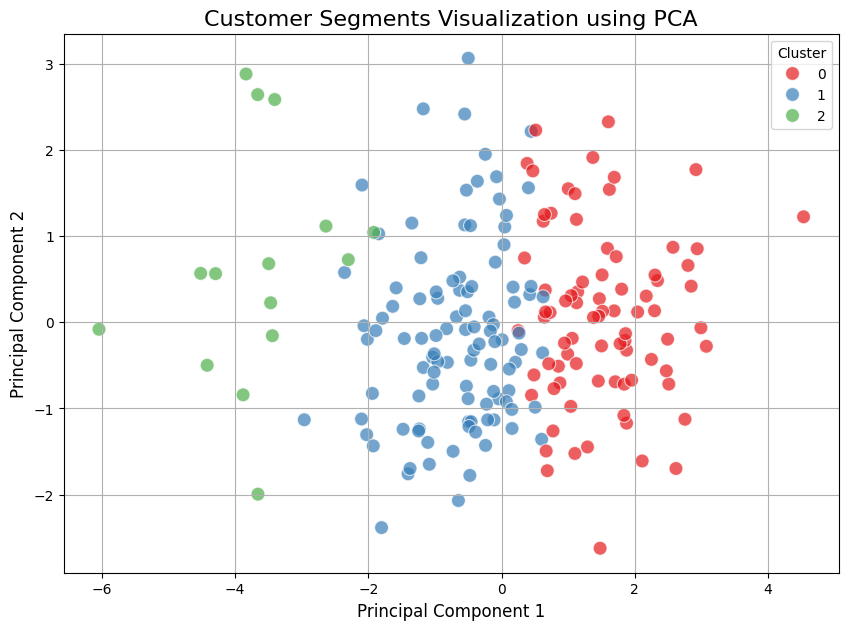

In [14]:

# Step 10: Visualizing the Clusters with PCA

# Reduce data to 2 principal components for visualization
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(feature_matrix)

# Create a DataFrame with principal components and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels
pca_df['CustomerID'] = customer_features['CustomerID']

# Plotting the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segments Visualization using PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [17]:
# Step 11: Analyzing Cluster Characteristics

# Define numerical and categorical features
numerical_features = ['TotalSpend', 'AvgTransactionValue', 'NumTransactions',
                      'TenureDays', 'DistinctCategories', 'Recency']
categorical_features = ['Region', 'FavoriteCategory']

# Calculate mean values of numerical features for each cluster
cluster_means = customer_features.groupby('Cluster')[numerical_features].mean().reset_index()
print("\nMean Values of Numerical Features per Cluster:")
print(cluster_means)

# Get the most common categorical attributes in each cluster
cluster_categ = customer_features.groupby('Cluster')[categorical_features].agg(lambda x: x.mode()[0]).reset_index()
print("\nMost Common Region and Favorite Category in Each Cluster:")
print(cluster_categ)


Analyzing cluster characteristics...

Mean Values of Numerical Features per Cluster:
   Cluster   TotalSpend  AvgTransactionValue  NumTransactions  TenureDays  \
0        0  5108.217901           752.536236         6.962963  503.111111   
1        1  2538.083846           656.475259         3.990385  557.865385   
2        2   817.946000           506.639611         1.400000  450.600000   

   DistinctCategories     Recency  
0            3.629630   55.358025  
1            2.471154   63.365385  
2            1.066667  270.666667  

Most Common Region and Favorite Category in Each Cluster:
   Cluster         Region FavoriteCategory
0        0  South America       Home Decor
1        1  South America            Books
2        2           Asia       Home Decor


In [18]:
# Step 12: Saving the Results
# Save the customer data with cluster labels
customer_features.to_csv('Customer_Segments.csv', index=False)

# Save the cluster analysis
cluster_means.to_csv('Cluster_Analysis.csv', index=False)
cluster_categ.to_csv('Cluster_Categorical_Analysis.csv', index=False)


Saving the clustered customer data and cluster analysis to CSV files...
Customer_Segments.csv has been saved.
Cluster analysis CSV files have been saved.


In [19]:
# Step 13: Summary Report
# ------------------------------
print("\n=== Customer Segmentation Report ===")
print(f"Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

print("\nCluster Distribution:")
print(customer_features['Cluster'].value_counts().sort_index())

print("\nCluster Mean Characteristics:")
print(cluster_means)

print("\nMost Common Region and Favorite Category in Each Cluster:")
print(cluster_categ)

print("\nVisualization and CSV exports completed successfully!")


=== Customer Segmentation Report ===
Number of Clusters: 3
Davies-Bouldin Index: 1.6595
Silhouette Score: 0.1815
Calinski-Harabasz Index: 49.2643

Cluster Distribution:
Cluster
0     81
1    104
2     15
Name: count, dtype: int64

Cluster Mean Characteristics:
   Cluster   TotalSpend  AvgTransactionValue  NumTransactions  TenureDays  \
0        0  5108.217901           752.536236         6.962963  503.111111   
1        1  2538.083846           656.475259         3.990385  557.865385   
2        2   817.946000           506.639611         1.400000  450.600000   

   DistinctCategories     Recency  
0            3.629630   55.358025  
1            2.471154   63.365385  
2            1.066667  270.666667  

Most Common Region and Favorite Category in Each Cluster:
   Cluster         Region FavoriteCategory
0        0  South America       Home Decor
1        1  South America            Books
2        2           Asia       Home Decor

Visualization and CSV exports completed successfully!